## Factores que llevan a los conductores a cumplir con los objetivos de distribución.

El objetivo de este problema es determinar los factores que pueden llevar a los conductores de ruta a cumplir con su objetivo de distribución deseada.

Se tiene identificado los conductores que llegan o no llegan a la distribución deseada.

Nuestro conjunto de datos cuenta con 29,389 rutas. 

Sin embargo, **5,878** rutas no cuentan con un identificador de distribución deseada o distribución no deseada. 

**¿Podemos inferir los valores faltantes por medio de los datos existentes?**

Variable target es **success** : contiene valores 0,1,-1 (Valores -1 son los datos faltantes). 

**Columnas**

- **anonId:** Identificador único de la ruta
- **birthdate:** Fecha de nacimiento del empleado
- **routeDate:** Día en que se realizó la ruta entre el 20/05/11 y el 20/05/22
- **region:** Zona del mundo donde se ejecutó la ruta:
    - NA: North America
    - AMESA: Africa, Middle East and South Asia
    - APAC: Asia Pacific, Australia/New Zealand, and China 
    - LATAM: Latin America
    - Europe
- **gender:** Género autodeterminado del empleado {F-Female, M-Male, X-Non binary}
- **areaWealthLevel:** Desarrollo de la zona económica, en comparación con el conjunto del país (Low, Mid or High)
- **areaPopulation:** Población de la zona cubierta, en miles
- **badWeather:** Malas condiciones meteorológicas en la zona, como precipitaciones o viento fuerte
- **weatheRestrictions:** Afectaciones en la zona debido al clima
- **routeTotalDistance:** Distancia de la ruta recorrida en kms
- **numberOfShops:** Total Tiendas que cubrimos en la zona
- **marketShare:** Porcentaje de cuota de mercado que la empresa tiene en la zona en sus categorías.
- **avgAreaBenefits:** Beneficio económico semanal en la zona (en miles de $)
- **timeFromAvg:** Tiempo empleado en la ruta, comparado con la media (negativo significaría que se tardó menos que la media
- **advertising:** Inversión en material de punto de venta en las tiendas (de 0, que significa que no se invierte, a 3, que se invierte mucho)
- **emoloyeeLYScore:** Calificando la puntuación del año pasado (de 1 a 5, siendo 5 la más alta). Los nuevos empleados tienen 3 por defecto.
- **employeeTenure:** Tiempo que el empleado lleva en la empresa
  - 0: se han incorporado en los últimos 12 meses 
  - 1: de 1 a 3 años
  - 2: de 3 a 10 años
  - 3: mas de 1O años
- **emploIoyeePrevComps:** Número de empresas en las que el empleado trabajó anteriormente desarrollando la misma función (5 significa 3 o más).
- **success:** El distribuidor ha distribuido al menos el valor esperado (1) o menos (0)

# 1. Funciones importantes del Notebook.

Preparación de datos (paquete **preparacion_datos**);
    
- *data_clean()*  : extracción, formato de columnas, limpieza de columnas.
- *data_model()*  : selección de columnas, ingeniería de características.
    
Modelado de datos (paquete **modelado_datos**) ; 
    
- *ml_clf_knn()* : primer modelo de clasificación knn, analísis sesgo y varianza, métricas curva ROC y AUC, predicciones.
- *ml_output()*  : exportación de resultados para cliente.

In [2]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import warnings
from datetime import datetime

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from mlxtend.evaluate import bias_variance_decomp
from sklearn.metrics import zero_one_loss

pio.templates.default = "ggplot2"
warnings.filterwarnings('ignore')
pio.renderers.default='jupyterlab'
pd.set_option('display.float_format', lambda x: '%.2g' % x)

In [4]:
from Utils import preparacionDatos
from Utils import mlDatos

with open('Inputs/deliveryDatasetChallenge.json') as json_file:
    data = json.load(json_file)
    
    print("Type:", type(data))


data = pd.DataFrame(data)

data = preparacionDatos.dataClean(data)
data.head()

Type: <class 'dict'>


,anonID,birthdate,edad,routeDate,month,day,year,region,gender,areaWealthLevel,...,routeTotalDistance,numberOfShops,marketShare,avgAreaBenefits,timeFromAvg,advertising,employeeLYScore,employeeTenure,employeePrevComps,success
0,XLKC1691,1969-10-23,52,2020-05-19,5,19,2020,NA,M,Mid,...,28,26,49,19,0.35,3,4,1,1,-1
1,KANY6459,1976-04-14,46,2020-05-19,5,19,2020,LATAM,M,Mid,...,21,28,96,14,0.47,3,4,3,2,-1
2,ULUZ5859,1985-03-04,37,NaT,nan,nan,nan,NA,M,High,...,26,25,76,14,0,2,3,1,1,-1
3,LDCQ7279,1968-03-24,54,2020-11-05,11,5,2020,NA,M,Mid,...,24,26,65,19,-0.37,2,4,3,2,-1
4,KIUB5860,1978-04-22,44,2020-05-19,5,19,2020,AMESA,M,Low,...,23,22,72,12,0.44,2,3,3,2,-1


**Datos para el modelo de machine learning (data_model).**

Descartamos columnas como cumpleaños y la convertimos en edad.

Variables categóricas texto las convertimos en variables categóricas númericas.

Redujimos el número de columnas de acuerdo a lo encontrado en los análisis exploratorios.


In [6]:
data_model = preparacionDatos.dataModel(data)

print(data_model.shape)
data_model.head()

(29389, 17)


,edad,region,gender,areaWealthLevel,badWeather,weatherRestrictions,areaPopulation,routeTotalDistance,numberOfShops,marketShare,avgAreaBenefits,timeFromAvg,advertising,employeeLYScore,employeeTenure,employeePrevComps,success
anonID,,,,,,,,,,,,,,,,,
XLKC1691,52,4,1,2,0,0,31,28,26,49,19,0.35,3,4,1,1,-1
KANY6459,46,3,1,2,0,0,52,21,28,96,14,0.47,3,4,3,2,-1
ULUZ5859,37,4,1,0,1,0,25,26,25,76,14,0,2,3,1,1,-1
LDCQ7279,54,4,1,2,0,0,37,24,26,65,19,-0.37,2,4,3,2,-1
KIUB5860,44,0,1,1,0,0,12,23,22,72,12,0.44,2,3,3,2,-1


# 2. Exploración de datos (Power BI)

- **Datos faltantes** : Análisis de completitud de la variable success. 

- **Características de conductores** : Edad, genero, evaluación de desempeño, antigüedad, número de trabajos anteriores.

- **Características de las rutas** : Tiempo que toma transcurrir una ruta, distancia total recorrida en kms.

- **Características geográficas** : Regiones, afectaciones en el clima, tamaño poblacional.

- **Características socioeconómicas** :  Desarrollo económico de la zona, número de tiendas que se cubren por ruta en la zona, porcentaje de mercado en la zona, ganancias/beneficios semanales por zona, inversión en los punto de venta.

- **Correlación de variables** :  ¿Existe alguna correlación positiva/negativa entre variables?


In [7]:
preparacionDatos.grupos(data,['success'],num_grupos=1)

,anonID
success,
-1,5878
0,864
1,22647


Temporalidad de eventos.

**Analísis data_model correlacion de Person columnas.**

In [70]:
#Tenemos 5 variables más o menos correlacionadas positivamente
#advertising ~ employeeLYScore     0.615878 => Entre mayor es la inversión mayor es la calificación
#employeeLYScore ~ areaPopulation     0.594624 
#badWeather ~ weatherRestrictions     0.408545 => Mal clima implica afectaciones en la zona.
#employeeTenure ~ employeePrevComps .35 => En ocasiones entre más tiempo tiene en la empresa ya estuvo en otras empresas.
#advertising ~ avgAreaBenefits     0.33 => En ocasiones entre mayor es la inversión mejores beneficios en la zona.
 
tmp = data_model.corr().reset_index()
tmp = tmp.melt(id_vars = 'index', value_vars =['edad', 'region', 'gender', 'areaWealthLevel', 'badWeather',
       'weatherRestrictions', 'areaPopulation', 'routeTotalDistance',
       'numberOfShops', 'marketShare', 'avgAreaBenefits', 'timeFromAvg',
       'advertising', 'employeeLYScore', 'employeeTenure',
       'employeePrevComps'], 
        var_name ='variable_corr', value_name ='corr_person').sort_values("corr_person",ascending = False)
tmp = tmp[tmp["corr_person"] != 1]
tmp.head(15)
#tmp.tail()

,index,variable_corr,corr_person
233,advertising,employeeLYScore,0.62
217,employeeLYScore,advertising,0.62
115,employeeLYScore,areaPopulation,0.59
227,areaPopulation,employeeLYScore,0.59
73,weatherRestrictions,badWeather,0.41
89,badWeather,weatherRestrictions,0.41
253,employeePrevComps,employeeTenure,0.36
269,employeeTenure,employeePrevComps,0.36
214,avgAreaBenefits,advertising,0.34
182,advertising,avgAreaBenefits,0.34


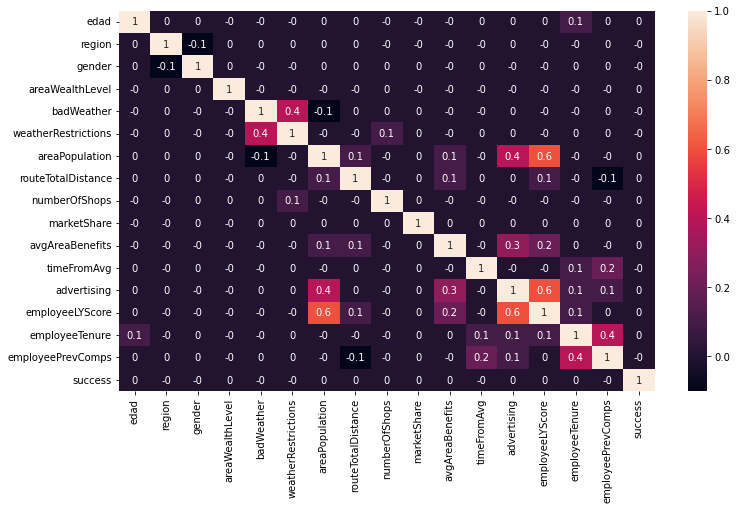

In [16]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [12, 7]
ax = sns.heatmap(round(data_model.corr(),1), annot = True)

# 3. Primer Modelo Clasificación Binaria.

**Modelo Clasificación KNN.**

*Propuesta Modelo : Supervisado -> Clasificación : KNeighborsClassifier*.

- Busqueda de hyperparametros : n_neigbors
- Análisis sesgo y varianza.
- Métricas de rendimiento para nuestro clasificador binario (Curva ROC y AUC).

In [17]:
#Datos preproceso ML.
data_model = preparacionDatos.dataModel(data)

preparacionDatos.grupos(data,['success'],num_grupos=1) #Lo valores -1 son los que queremos predecir.

#Datos de prueba
data_prueba = data_model[data_model["success"] == -1]

#Datos de test y datos de entrenamiento.
data_model = data_model[data_model["success"] != -1]

x, y = data_model.iloc[:,:-1], data_model.success
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 123, stratify = y)
y_test.value_counts(normalize = True)
y_train.value_counts(normalize = True)
x_train.head()

,edad,region,gender,areaWealthLevel,badWeather,weatherRestrictions,areaPopulation,routeTotalDistance,numberOfShops,marketShare,avgAreaBenefits,timeFromAvg,advertising,employeeLYScore,employeeTenure,employeePrevComps
anonID,,,,,,,,,,,,,,,,
IGZB9173,47,0,1,2,1,0,9.7,24,24,65,19,0,3,3,0,2
FGNX4207,41,1,1,3,0,0,28,26,23,64,22,-0.12,2,3,0,1
GGWU3395,48,3,1,2,0,0,7.8,22,27,67,13,-0.09,0,3,2,1
OFNI8818,51,0,1,1,0,0,9.3,22,29,98,14,0,0,1,2,1
KLIS7697,49,1,1,1,1,0,5.2,28,28,62,18,0,1,3,2,1


Al modelar con KNN, buscaremos un *n_neigbors* "óptimo".

Buscamos el punto en el que los datos no cometan Overfiting o Undergiting. 

Graficando y variando el numero de n_neighbors y su presición, podemos encontrar el punto "óptimo" para encontrar un equilibrio.

Text(2, 0.93, 'Underfiting : Alto sesgo, baja varianza.')

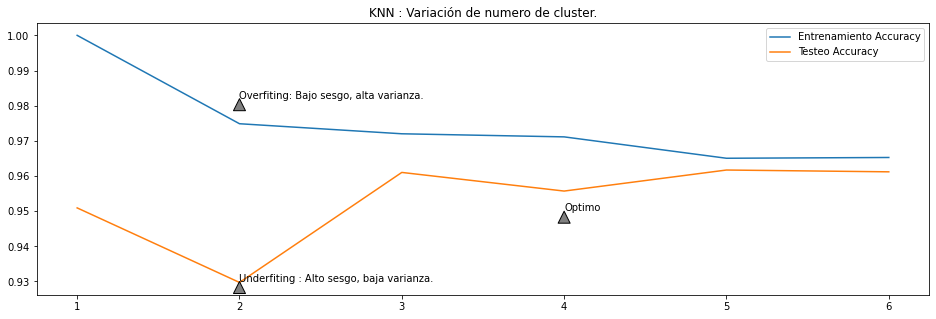

In [30]:
#Grafica variando el numero de n_neighbors y su presición.
n_neighbors = range(1,7)
train  = []
test = []

for i in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)
    
    train.append(knn.score(x_train, y_train))
    test.append(knn.score(x_test, y_test))

plt.rcParams['figure.figsize'] = [16, 5]
line_up, = plt.plot(n_neighbors, train , label='Entrenamiento Accuracy')
line_down, = plt.plot(n_neighbors, test, label='Testeo Accuracy')
plt.title("KNN : Variación de numero de cluster.")
plt.legend([line_up, line_down], ['Entrenamiento Accuracy', 'Testeo Accuracy'])

plt.annotate('Overfiting: Bajo sesgo, alta varianza.', xy = (2, .982), arrowprops = {'facecolor':'gray', 'width': 3, 'shrink': 0.03})
plt.annotate('Optimo', xy = (5, .95), arrowprops = {'facecolor':'gray', 'width': 3, 'shrink': 0.03})
plt.annotate('Underfiting : Alto sesgo, baja varianza.', xy = (2, .93), arrowprops = {'facecolor':'gray', 'width': 3, 'shrink': 0.03})

Analísis Sesgo y Varianza de nuestos modelo Knn.

n_neighbors 1
Pérdida media esperada 0.05326436388508892
Media bias 0.049076607387140904
Media variance 0.02254616963064296
------
n_neighbors 2
Pérdida media esperada 0.0669391244870041
Media bias 0.05694254445964432
Media variance 0.03859610123119015
------
n_neighbors 3
Pérdida media esperada 0.05104907660738714
Media bias 0.036935704514363885
Media variance 0.023880813953488372
------
n_neighbors 4
Pérdida media esperada 0.05881070451436389
Media bias 0.03984268125854993
Media variance 0.03310106019151847
------
n_neighbors 5
Pérdida media esperada 0.04562072503419973
Media bias 0.0377906976744186
Media variance 0.014131326949384406
------
n_neighbors 6
Pérdida media esperada 0.04913474692202462
Media bias 0.03796169630642955
Media variance 0.018758549931600546
------
n_neighbors 7
Pérdida media esperada 0.041616792065663474
Media bias 0.03744870041039672
Media variance 0.007317886456908345
------


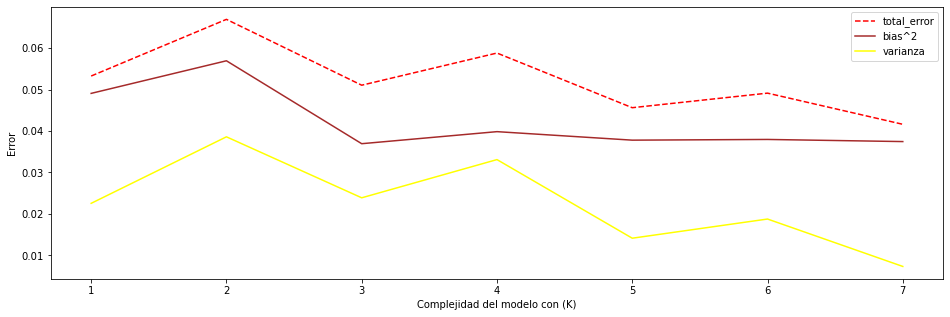

In [72]:
#Para varios valores de k en kNN, examinemos también cómo van a ser nuestras pérdidas, sesgos y varianzas
bias_KnnClass, var_KnnClass,error_KnnClass, = [], [], []
for k in range(1,8):
    clf_knn = KNeighborsClassifier(n_neighbors=k)
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(clf_knn, x_train.values, y_train.values, x_test.values, y_test.values, loss = '0-1_loss', random_seed = 123)
    bias_KnnClass.append(avg_bias)
    var_KnnClass.append(avg_var)
    error_KnnClass.append(avg_expected_loss)
    print(f"n_neighbors {k}")
    print(f"Pérdida media esperada {avg_expected_loss}")
    print(f"Media bias {avg_bias}")
    print(f"Media variance {avg_var}")
    print("------")

plt.rcParams['figure.figsize'] = [16, 5]
plt.plot(range(1,8), error_KnnClass, 'red', label = 'total_error',linestyle='dashed')
plt.plot(range(1,8), bias_KnnClass, 'brown', label = 'bias^2')
plt.plot(range(1,8), var_KnnClass, 'yellow', label = 'varianza')
plt.xlabel('Complejidad del modelo con (K)')
plt.ylabel('Error')
plt.legend()

Mejor modelo de acuerdo a Sesgo y Varianza -> **n_neighbors=4**.

In [78]:
#Mejor modelo analizando knn con Sesgo y Varianza.
clf_knn = KNeighborsClassifier(n_neighbors=4)
clf_knn.fit(x_train, y_train)
score = clf_knn.score(x_train, y_train)
print("Score: ", score)

y_pred = clf_knn.predict(x_test)

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(clf_knn, x_train.values, y_train.values, x_test.values, y_test.values, loss = '0-1_loss', random_seed = 123)
print('Pérdida media esperada: %.3f' % avg_expected_loss)
print('Media Bias: %.3f' % avg_bias)
print('Media Variance: %.3f' % avg_var)
print('Skelarn 0-1 perdida : %.3f' % zero_one_loss(y_test, y_pred))

Score:  0.9711249541956761
Pérdida media esperada: 0.059
Media Bias: 0.040
Media Variance: 0.033
Skelarn 0-1 perdida : 0.044


**Métricas de rendimiento para nuestro clasificador binario.**

Tabla de contingencia , curva ROC y areá AUC.

In [79]:
#Métricas de Clásificación para nuestro modelo knn = 4.
#     Predicted: 0   Predicted: 1
#0    True Positive  False Negative
#1    False Positive True Negative

cm = confusion_matrix(y_test, y_pred)
y_test.value_counts()
print(cm)

accuracy_score(y_test, y_pred) #Porcentaje total de valores correctamente clasificados, tanto positivos como negativos.
precision_score(y_test, y_pred) #Saber qué porcentaje de valores que se han clasificado como positivos son realmente positivos.
recall_score(y_test, y_pred) #Cuantos valores positivos son correctamente clasificados.
f1_score(y_test, y_pred) #

cr = classification_report(y_test, y_pred)
print(cr)

[[  28  191]
 [  68 5561]]
              precision    recall  f1-score   support

           0       0.29      0.13      0.18       219
           1       0.97      0.99      0.98      5629

    accuracy                           0.96      5848
   macro avg       0.63      0.56      0.58      5848
weighted avg       0.94      0.96      0.95      5848



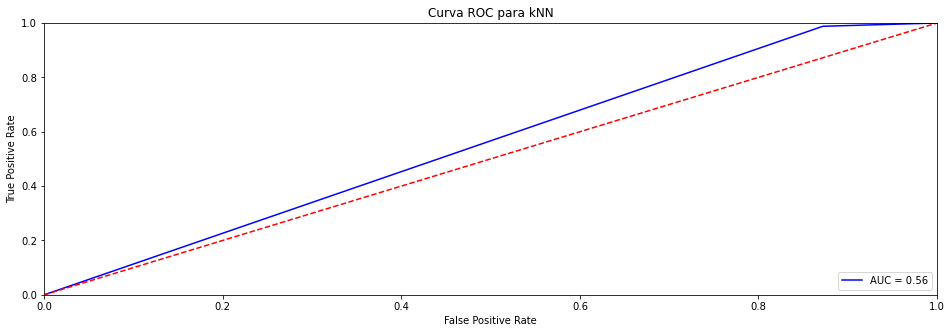

In [80]:
#Curva Roc
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Característica operativa del receptor.')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Curva ROC para kNN')
plt.show()

# 4. Resultados y siguientes pasos.

- La función *ml_cfl_knn()* : Contiene la lógica del modelo y los mejores Hyperparametros.


In [102]:
pd.read_csv("C:/Users/cflorelu/Documents/Github/DataChallenge/Outputs/data_output.csv").iloc[:,[1,2,3]]

,anonID,success_real,success_pred
0,IGVB3191,1,1
1,YWGU4220,1,1
2,OSDN4594,1,1
3,BIMU7017,1,1
4,EESX2634,1,1
...,...,...,...
5843,QBMC1449,1,1
5844,UJPW9775,1,1
5845,HFHK4106,1,1
5846,GWFH2494,1,1


**Knn : No dio los mejores resultados para está clasificación, dado que cometé varios errores al momento de clasificar.**

**Siguiente iteración :**
- 1. Seguir exploración de variables e insights.
- 2. Ver si ayuda la estandarización, normalización, escalado de datos antes de entrenar los modelos.
- 3. Exploración de Hyperparametros para KNN.
- 4. Tuneo de Hyperparametros (GridSearch).
- 5. Validación Cruzada.
- 6. Probar otro modelo como : SVC, LogisticRegression, RandomClassifier, etc...

# 5. Despliegue y documentación.

El paquete y la estructura se subieron al siguiente Github : https://github.com/Corderodedios182/DataChallenge